In [6]:
## By Jennifer Hill, 2021
## Adapted from Akamatsu et al., 2020, eLife
## Plot internalization, actin, Arp2/3, and crosslinkers for multiple groups of simulations with varying parameters (multiple run groups) 

import pickle
import sys
import pandas as pd
import numpy as np
import os

# set directory path names
working_dir = '/Users/jenniferhill/Documents/tubeZsavio/experiments/'

output_name = 'endocytosis'

output_dir = working_dir + 'longbudtime_1000pN_output_11968314/'

figures_dir = output_dir + 'figures/'

# decide whether to load actin positions and forces
load_actin_positions_forces = 'yes'

os.chdir(working_dir)

solid_positions = pd.read_pickle(output_dir+'/dataframes/bud_positions.pkl')

all_xlinks = pd.read_pickle(output_dir+'/dataframes/all_xlinks.pkl')

xlinks_state = pd.read_pickle(output_dir+'/dataframes/xlinks_state.pkl')

bound_arp  = pd.read_pickle(output_dir+'/dataframes/bound_arp.pkl')

actin_ends = pd.read_pickle(output_dir+'/dataframes/actin_plus_minus_ends_recal.pkl')

if load_actin_positions_forces =='yes':
   
    with open(output_dir+'/dataframes/actin_positions_forces.pkl', 'rb') as f:
        new_actin_pos = pickle.load(f, encoding='latin1') 
        
# set to 'yes' to save figures in figures_dir
save_figures='no'

#set to True for plots with black backgrounds
dark_plot_style=False

print('all dataframes loaded')

all dataframes loaded


## Set plot styles

In [7]:
import matplotlib.pyplot as plt  # plotting
if dark_plot_style == True:
    plt.style.use('dark_background')
else:
    plt.style.use('seaborn-v0_8-colorblind') # set plot style
plt.cool()                          # heatmap color scheme
%matplotlib inline

import seaborn as sns  # nicer plotting
sns.set_style('whitegrid')  # set plot style

from matplotlib.pyplot import cm

from scipy.stats import binned_statistic_2d

SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# define functions that plot means and standard deviations for multiple run groups

def plot_multiple_errorbars(means, stds, c, label):

    # You can call this multiple times to make several plots on top of each other. 

    color=c
    
    # plot means in the given color
    plt.plot(means.index,means, c=color)
    times_cur = means.index
    # calculate upper and lower bounds based on stds
    yminus=means-stds
    yplus=means+stds
    
    # plot stds and fill between stds and means
    plt.fill_between(times_cur, np.asarray(yminus), np.asarray(yplus), 
                     alpha=0.25,edgecolor=color, facecolor=color, linewidth=1, antialiased=True) 

    plt.xlabel('Time (s)')
    plt.ylabel(label)

    plt.tick_params(reset=True, color='black', direction='in', length=4)
    plt.grid(False)
    
def plot_multiple_errorbars_indexed(means, stds, c, label):

    # You can call this multiple times to make several plots on top of each other.
    # Use for plotting from dfs with indexed columns

    color=c
    
    # plot means in the given color
    plt.plot(means.index,means, c=color)
    times_cur = means.index
    # calculate upper and lower bounds based on stds and take column to drop index
    yminus=means-stds
    yminus_col=yminus.iloc[:,0]
    yplus=means+stds
    yplus_col=yplus.iloc[:,0]
    
    # plot stds and fill between stds and means
    plt.fill_between(times_cur, np.asarray(yminus_col), np.asarray(yplus_col), 
                     alpha=0.25,edgecolor=color, facecolor=color, linewidth=1, antialiased=True) 

    plt.xlabel('Time (s)')
    plt.ylabel(label)

    plt.tick_params(reset=True, color='black', direction='in', length=4)
    plt.grid(False) 

    
import datetime
    
now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date+'_'+output_name
print(pref)

20240227_endocytosis


<Figure size 640x480 with 0 Axes>

## Plot internalization over time

In [11]:
##PLOT INTERNALIZATION OVER TIME

#make lists for the time points and runs in the dataset

time, run = [], [] #make lists for time and run values

#for each fiber_id item (v) in each index (run and time, k) in actin_ends, append the 1 index to time and the 0 index to run
for k, v in solid_positions.zpos.items(): 
    time.append(k[1])
    run.append(k[0])

#add columns to new_actin_pos for test_time and test_run from the time and run lists
solid_positions['Test_time'] = pd.Series(time, index=solid_positions.index)
solid_positions['Test_run'] = pd.Series(run, index=solid_positions.index)

#runs is a sorted list of the unique values in the test_run column of actin_ends
runs   = sorted(list(set(solid_positions.Test_run)), key = lambda x:int(x[-2:]))
#times is a sorted list of the unique values in the test_column of actin_ends
times = sorted(list(set(solid_positions.Test_time)))

solid_positions.head()

xpos      ypos      zpos  internalization  \
run          time id                                                  
run0011_0001 0.00 1   0.000000  0.000000 -0.140000            0.000   
             0.03 1  -0.003566 -0.001854 -0.142186           -2.186   
             0.06 1  -0.003011 -0.004338 -0.142251           -2.251   
             0.09 1   0.001571 -0.006309 -0.142088           -2.088   
             0.12 1   0.002173  0.003591 -0.142353           -2.353   

                      Test_time      Test_run Run_group  
run          time id                                     
run0011_0001 0.00 1        0.00  run0011_0001   run0011  
             0.03 1        0.03  run0011_0001   run0011  
             0.06 1        0.06  run0011_0001   run0011  
             0.09 1        0.09  run0011_0001   run0011  
             0.12 1        0.12  run0011_0001   run0011

In [12]:
#generate 90th percentiles of internalization for individual runs and save to figures_dir

solid_int = solid_positions['internalization'].groupby('run').quantile(.90).to_frame()
solid_int.to_csv(figures_dir+'90th_percentile_int.csv')
solid_int.head()

,internalization
run,
run0000_0000,44.57427
run0000_0001,41.07298
run0000_0002,34.09040
run0000_0003,41.93878
run0000_0004,43.87049


In [13]:
#make a list for the groups of repeated runs in the dataset

run_group = [] #make a list for run_groups

#for every value in the run index (aka every unique value in the Test_run column of new_actin_pos) 
for x in run:
    run_value = x.split('_')[0] #split the string at the '_' and assign the first item (run****) to run_value
    run_group.append(run_value) #append run_value to the run_group list

#add a column to new_actin_pos for Run_groups using the run_group list and the new_actin_pos index
solid_positions['Run_group'] = pd.Series(run_group, index=solid_positions.index)

#run_groups is a sorted list of the unique values in the column Run_group
run_groups = sorted(list(set(solid_positions.Run_group)))

solid_positions.head()

xpos      ypos      zpos  internalization  \
run          time id                                                  
run0011_0001 0.00 1   0.000000  0.000000 -0.140000            0.000   
             0.03 1  -0.003566 -0.001854 -0.142186           -2.186   
             0.06 1  -0.003011 -0.004338 -0.142251           -2.251   
             0.09 1   0.001571 -0.006309 -0.142088           -2.088   
             0.12 1   0.002173  0.003591 -0.142353           -2.353   

                      Test_time      Test_run Run_group  
run          time id                                     
run0011_0001 0.00 1        0.00  run0011_0001   run0011  
             0.03 1        0.03  run0011_0001   run0011  
             0.06 1        0.06  run0011_0001   run0011  
             0.09 1        0.09  run0011_0001   run0011  
             0.12 1        0.12  run0011_0001   run0011

In [15]:
#generate dfs for the means and stds of solid positions for every time point for each group of repeated runs

run_grouped = solid_positions.groupby(solid_positions.Run_group)

solid_positions_by_run_group = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the solid_pos df that contain the current run group
    solid_positions_run_group = run_grouped.get_group("%s"%i)
    #append that df to the list of dfs for each run group
    solid_positions_by_run_group.append(solid_positions_run_group)
    
position_by_group_mean = []
position_by_group_std = []

#for each df in the list of dfs by run group
for i in solid_positions_by_run_group:
    #calculate the means and stds and append them to the list as an item for that run group
    position_by_time_mean = i.groupby(level='time').internalization.mean()
    position_by_group_mean.append(position_by_time_mean)
    position_by_time_std = i.groupby(level='time').internalization.std()
    position_by_group_std.append(position_by_time_std)

#concatenate into a single data frame with times as index and names of each column are run_groups
position_by_group_mean_all = pd.concat(position_by_group_mean, axis=1,
                                            keys=run_groups)
position_by_group_std_all = pd.concat(position_by_group_std, axis=1,
                                           keys=run_groups)

position_by_group_mean_all.head()

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
time,,,,,,,,,,,,,,
0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0.03,-2.1914,-2.1866,-2.2716,-2.1344,-2.2210,-2.3084,-2.2414,-2.1640,-2.2588,-2.1786,-2.2434,-2.1618,-2.2210,-2.1870
0.06,-2.1536,-2.2418,-2.2066,-2.1322,-2.2264,-2.2158,-2.2422,-2.1860,-2.1274,-2.1978,-2.2126,-2.2568,-2.3246,-2.4928
0.09,-2.1570,-2.1784,-2.1546,-2.0526,-2.2718,-2.2096,-2.2316,-2.1700,-1.9978,-2.2270,-2.0742,-2.1588,-2.1666,-2.1960
0.12,-2.1898,-2.1636,-2.1324,-2.2170,-2.1224,-2.1520,-2.2226,-2.0854,-2.1952,-2.1798,-2.1878,-2.2268,-2.2668,-2.2404


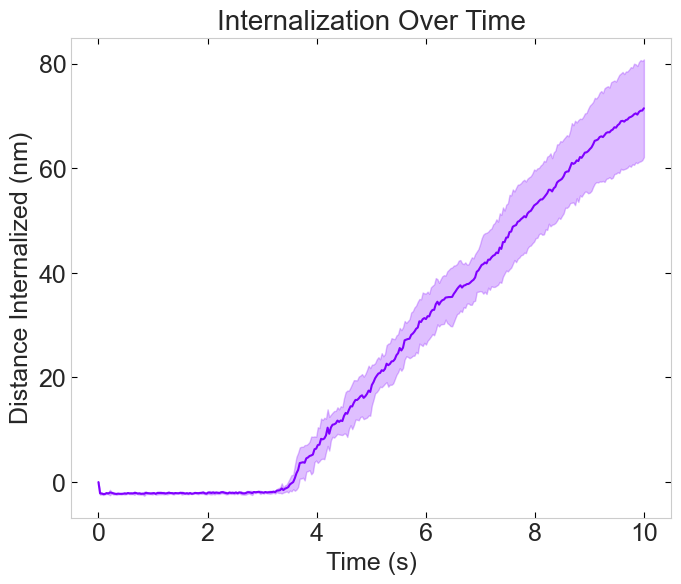

In [83]:
#plot internalization over time

fig = plt.figure(figsize=[10,8])
ax = fig.add_axes([0.28, 0.2, 0.6, 0.6])

#assign a color to each run group
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars(position_by_group_mean_all["%s"%group], position_by_group_std_all["%s"%group], c, 'Distance Internalized (nm)')

plt.title('Internalization Over Time')

if save_figures == 'yes':
    plt.savefig(figures_dir+'position_vs_time.png')
    plt.savefig(figures_dir+'position_vs_time.pdf')

    position_by_group_mean_all.to_csv(figures_dir+'solid_pos_mean.csv')
    position_by_group_std_all.to_csv(figures_dir+'solid_pos_std.csv')

## Plot actin monomers and polymerization energy over time

In [16]:
#make lists for the time points and runs in the dataset

time, run = [], [] #make lists for time and run values

#for each fiber_id item (v) in each index (run and time, k) in actin_ends, append the 1 index to time and the 0 index to run
for k, v in new_actin_pos.fiber_id.items(): 
    time.append(k[1])
    run.append(k[0])

#add columns to new_actin_pos for test_time and test_run from the time and run lists
new_actin_pos['Test_time'] = pd.Series(time, index=new_actin_pos.index)
new_actin_pos['Test_run'] = pd.Series(run, index=new_actin_pos.index)

#runs is a sorted list of the unique values in the test_run column of actin_ends
runs   = sorted(list(set(new_actin_pos.Test_run)), key = lambda x:int(x[-2:]))
#times is a sorted list of the unique values in the test_column of actin_ends
times = sorted(list(set(new_actin_pos.Test_time)))

new_actin_pos.head()

fiber_id  pt_index      xpos      ypos      zpos  \
run          time id                                                      
run0011_0001 0.0  1_0         1         0 -0.004209  0.014234 -0.032165   
                  1_1         1         1 -0.002525  0.008540 -0.031299   
                  1_2         1         2 -0.000842  0.002847 -0.030433   
                  1_3         1         3  0.000842 -0.002847 -0.029567   
                  1_4         1         4  0.002525 -0.008540 -0.028701   

                        xforce    yforce   zforce   tension  force_magnitude  \
run          time id                                                           
run0011_0001 0.0  1_0  780.106 -2745.160  595.349 -2405.050      2915.288876   
                  1_1 -228.206   269.053  327.086 -1628.230       481.095361   
                  1_2 -647.480   376.612  589.304  -669.533       953.071956   
                  1_3  500.733  -428.214 -621.606  -621.976       905.811673   
                  1_4  228.206  -269.053 -262.138  -398.798       439.526821   

                       Test_time      Test_run  
run          time id                            
run0011_0001 0.0  1_0        0.0  run0011_0001  
                  1_1        0.0  run0011_0001  
                  1_2        0.0  run0011_0001  
                  1_3        0.0  run0011_0001  
                  1_4        0.0  run0011_0001

In [17]:
#make a list for the groups of repeated runs in the dataset

run_group = [] #make a list for run_groups

#for every value in the run index (aka every unique value in the Test_run column of new_actin_pos) 
for x in run:
    run_value = x.split('_')[0] #split the string at the '_' and assign the first item (run****) to run_value
    run_group.append(run_value) #append run_value to the run_group list

#add a column to new_actin_pos for Run_groups using the run_group list and the new_actin_pos index
new_actin_pos['Run_group'] = pd.Series(run_group, index=new_actin_pos.index)

#run_groups is a sorted list of the unique values in the column Run_group
run_groups = sorted(list(set(new_actin_pos.Run_group)))

new_actin_pos.head()

fiber_id  pt_index      xpos      ypos      zpos  \
run          time id                                                      
run0011_0001 0.0  1_0         1         0 -0.004209  0.014234 -0.032165   
                  1_1         1         1 -0.002525  0.008540 -0.031299   
                  1_2         1         2 -0.000842  0.002847 -0.030433   
                  1_3         1         3  0.000842 -0.002847 -0.029567   
                  1_4         1         4  0.002525 -0.008540 -0.028701   

                        xforce    yforce   zforce   tension  force_magnitude  \
run          time id                                                           
run0011_0001 0.0  1_0  780.106 -2745.160  595.349 -2405.050      2915.288876   
                  1_1 -228.206   269.053  327.086 -1628.230       481.095361   
                  1_2 -647.480   376.612  589.304  -669.533       953.071956   
                  1_3  500.733  -428.214 -621.606  -621.976       905.811673   
                  1_4  228.206  -269.053 -262.138  -398.798       439.526821   

                       Test_time      Test_run Run_group  
run          time id                                      
run0011_0001 0.0  1_0        0.0  run0011_0001   run0011  
                  1_1        0.0  run0011_0001   run0011  
                  1_2        0.0  run0011_0001   run0011  
                  1_3        0.0  run0011_0001   run0011  
                  1_4        0.0  run0011_0001   run0011

In [18]:
#generate dfs for the means and stds of actin monomers for every time point for each group of repeated runs

run_grouped = new_actin_pos.groupby(new_actin_pos.Run_group)

new_actin_pos_by_run_group = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the new_actin_pos df that contain the current run group
    new_actin_pos_run_group = run_grouped.get_group("%s"%i)
    #append that df to the list of dfs for each run group
    new_actin_pos_by_run_group.append(new_actin_pos_run_group)

actin_monomers_by_group_mean = []
actin_monomers_by_group_std = []

#for each df in the list of dfs by run group
for i in new_actin_pos_by_run_group:
    #group lines in the df by run and then time and get the number of lines for each time index 
    #(each line represents a segment of the actin filament)
    actin_points_by_run_time = i.groupby(level=['run', 'time']).pt_index.count()
    #convert to monomers (each segment is .0055 um and contains four monomers)
    actin_monomers_by_run_time = actin_points_by_run_time*4
    
    #calculate the means and stds and append them to the list as an item for that run group
    actin_monomers_by_time_mean = pd.DataFrame(actin_monomers_by_run_time).groupby('time').mean()
    actin_monomers_by_group_mean.append(actin_monomers_by_time_mean)
    actin_monomers_by_time_std = pd.DataFrame(actin_monomers_by_run_time).groupby('time').std()
    actin_monomers_by_group_std.append(actin_monomers_by_time_std)

#concatenate into a single data frame with times as index and names of each column are run_groups
actin_monomers_by_group_mean_all = pd.concat(actin_monomers_by_group_mean, axis=1,
                                            keys=run_groups)
actin_monomers_by_group_std_all = pd.concat(actin_monomers_by_group_std, axis=1,
                                           keys=run_groups)

actin_monomers_by_group_mean_all

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index,pt_index
time,,,,,,,,,,,,,,
0.0000,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0
0.0300,140.0,136.8,136.8,145.6,136.0,137.6,132.0,136.8,139.2,132.0,142.4,144.8,135.2,131.2
0.0600,156.0,148.8,154.4,161.6,144.0,151.2,149.6,149.6,168.8,148.0,153.6,164.8,144.0,152.0
0.0900,167.2,156.8,173.6,175.2,148.8,158.4,155.2,156.8,197.6,155.2,153.6,200.8,146.4,158.4
0.1200,180.8,168.0,198.4,208.0,156.0,173.6,158.4,167.2,232.0,175.2,153.6,227.2,163.2,188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.8798,12653.6,13421.6,13446.4,13128.8,12771.2,12260.0,12311.2,12108.0,11968.0,12875.2,11872.8,11243.2,11322.4,11506.4
9.9098,12703.2,13531.2,13484.0,13203.2,12804.0,12338.4,12370.4,12159.2,12027.2,12920.8,11925.6,11296.0,11370.4,11586.4


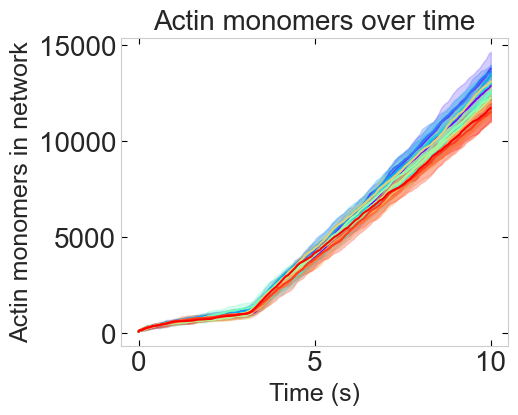

In [51]:
#plot actin monomers over time

plt.figure(figsize=(5,4))
plt.rc('font', size=20) 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

#assign a color to each run group 
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars_indexed(actin_monomers_by_group_mean_all['%s'%group], actin_monomers_by_group_std_all['%s'%group], c, 'Actin monomers in network')

plt.title('Actin monomers over time')

if save_figures == 'yes':
    plt.savefig(figures_dir+pref+'actin_monomers_vs_time.png')
    plt.savefig(figures_dir+pref+'actin_monomers_vs_time.pdf')
    
    actin_monomers_by_group_mean_all.to_csv(figures_dir+'total_actin.csv')
    actin_monomers_by_group_std_all.to_csv(figures_dir+'total_actin_std.csv')

plt.show()

## Plot Arp2/3 molecules over time

In [28]:
#make lists for the time points and runs in the dataset

time, run = [], []#make lists for time and run values

#for each arp_id item (v) in each index (run and time, k) in bound_arp, append the 1 index to time and the 0 index to run
for k, v in bound_arp.arp_id.items(): 
    time.append(k[1])
    run.append(k[0])

#add columns to bound_arp for test_time and test_run from the time and run lists
bound_arp['Test_time'] = pd.Series(time, index=bound_arp.index)
bound_arp['Test_run'] = pd.Series(run, index=bound_arp.index)

#runs is a sorted list of the unique values in the test_run column of bound_arp
runs   = sorted(list(set(bound_arp.Test_run)), key = lambda x:int(x[-2:]))
#times is a sorted list of the unique values in the test_column of bound_arp
times = sorted(list(set(bound_arp.Test_time)))

bound_arp

bound_state  arp_id      xpos      ypos      zpos  \
run          time  id                                                       
run0004_0002 0.15  4              1       4 -0.017534  0.000385 -0.024332   
                   2              1       2 -0.001688  0.019622 -0.028632   
                   1              1       1  0.002651 -0.019221  0.000855   
             0.18  4              1       4 -0.013379  0.002081 -0.027190   
                   2              1       2 -0.001512  0.017650 -0.024745   
...                             ...     ...       ...       ...       ...   
run0002_0001 10.00 737            1     737  0.002769 -0.048879  0.035119   
                   925            1     925 -0.027320 -0.057487 -0.012000   
                   937            1     937 -0.015599 -0.066487  0.001571   
                   768            1     768 -0.031752  0.015500  0.066969   
                   796            1     796 -0.020453 -0.013346  0.029492   

                        id_fiber1  abscissa1  id_fiber2  abscissa2  Test_time  \
run          time  id                                                           
run0004_0002 0.15  4            2   0.012352          0        NaN       0.15   
                   2            1   0.018638          0        NaN       0.15   
                   1            3   0.025371          4        0.0       0.15   
             0.18  4            2   0.012352          6        0.0       0.18   
                   2            1   0.018638          5        0.0       0.18   
...                           ...        ...        ...        ...        ...   
run0002_0001 10.00 737         29   0.013451         41        0.0      10.00   
                   925        224   0.005382        226        0.0      10.00   
                   937        192   0.027267        238        0.0      10.00   
                   768         44   0.013774         68        0.0      10.00   
                   796         52   0.026635         98        0.0      10.00   

                            Test_run  
run          time  id                 
run0004_0002 0.15  4    run0004_0002  
                   2    run0004_0002  
                   1    run0004_0002  
             0.18  4    run0004_0002  
                   2    run0004_0002  
...                              ...  
run0002_0001 10.00 737  run0002_0001  
                   925  run0002_0001  
                   937  run0002_0001  
                   768  run0002_0001  
                   796  run0002_0001  

[2552859 rows x 11 columns]

In [30]:
#make a list for the groups of repeated runs in the dataset

run_group = [] #make a list for run_groups

#for every value in the run index (aka every unique value in the Test_run column of bound_arp) 
for x in run:
    run_value = x.split('_')[0] #split the string at the '_' and assign the first item (run****) to run_value
    run_group.append(run_value) #append run_value to the run_group list 

#add a column to bound_arp for Run_groups using the run_group list and the bound_arp index
bound_arp['Run_group'] = pd.Series(run_group, index=bound_arp.index)

#run_groups is a sorted list of the unique values in the column Run_group
run_groups = sorted(list(set(bound_arp.Run_group)))

bound_arp

bound_state  arp_id      xpos      ypos      zpos  \
run          time  id                                                       
run0004_0002 0.15  4              1       4 -0.017534  0.000385 -0.024332   
                   2              1       2 -0.001688  0.019622 -0.028632   
                   1              1       1  0.002651 -0.019221  0.000855   
             0.18  4              1       4 -0.013379  0.002081 -0.027190   
                   2              1       2 -0.001512  0.017650 -0.024745   
...                             ...     ...       ...       ...       ...   
run0002_0001 10.00 737            1     737  0.002769 -0.048879  0.035119   
                   925            1     925 -0.027320 -0.057487 -0.012000   
                   937            1     937 -0.015599 -0.066487  0.001571   
                   768            1     768 -0.031752  0.015500  0.066969   
                   796            1     796 -0.020453 -0.013346  0.029492   

                        id_fiber1  abscissa1  id_fiber2  abscissa2  Test_time  \
run          time  id                                                           
run0004_0002 0.15  4            2   0.012352          0        NaN       0.15   
                   2            1   0.018638          0        NaN       0.15   
                   1            3   0.025371          4        0.0       0.15   
             0.18  4            2   0.012352          6        0.0       0.18   
                   2            1   0.018638          5        0.0       0.18   
...                           ...        ...        ...        ...        ...   
run0002_0001 10.00 737         29   0.013451         41        0.0      10.00   
                   925        224   0.005382        226        0.0      10.00   
                   937        192   0.027267        238        0.0      10.00   
                   768         44   0.013774         68        0.0      10.00   
                   796         52   0.026635         98        0.0      10.00   

                            Test_run Run_group  
run          time  id                           
run0004_0002 0.15  4    run0004_0002   run0004  
                   2    run0004_0002   run0004  
                   1    run0004_0002   run0004  
             0.18  4    run0004_0002   run0004  
                   2    run0004_0002   run0004  
...                              ...       ...  
run0002_0001 10.00 737  run0002_0001   run0002  
                   925  run0002_0001   run0002  
                   937  run0002_0001   run0002  
                   768  run0002_0001   run0002  
                   796  run0002_0001   run0002  

[2552859 rows x 12 columns]

In [31]:
#generate dfs for the means and stds of actin monomers for every time point for each group of repeated runs

run_grouped = bound_arp.groupby(bound_arp.Run_group)

arp_bound_by_run_group = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the bound_arp df that contain the current run group
    arp_bound_run_group = run_grouped.get_group("%s"%i)
    #append that df to the list of dfs for each run group
    arp_bound_by_run_group.append(arp_bound_run_group)

arp_bound_by_group_mean = []
arp_bound_by_group_std = []

#for each df in the list of dfs by run group
for i in arp_bound_by_run_group:
    #group lines in the df by run and then time and get the number of lines for each time index 
    #(each line represents a unique arp2/3 molecule)
    arp_bound_by_run_time = i.groupby(level=['run', 'time']).arp_id.count()
    
    #calculate the means and stds and append them to the list as an item for that run group
    arp_bound_by_time_mean = pd.DataFrame(arp_bound_by_run_time).groupby('time').mean()
    arp_bound_by_group_mean.append(arp_bound_by_time_mean)
    arp_bound_by_time_std = pd.DataFrame(arp_bound_by_run_time).groupby('time').std()
    arp_bound_by_group_std.append(arp_bound_by_time_std)

#concatenate into a single data frame with times as index and names of each column are run_groups
arp_bound_by_group_mean_all = pd.concat(arp_bound_by_group_mean, axis=1,
                                            keys=run_groups)
arp_bound_by_group_std_all = pd.concat(arp_bound_by_group_std, axis=1,
                                           keys=run_groups)

arp_bound_by_group_mean_all = arp_bound_by_group_mean_all.sort_index()
arp_bound_by_group_std_all = arp_bound_by_group_std_all.sort_index()
arp_bound_by_group_mean_all

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id,arp_id
time,,,,,,,,,,,,,,
0.0300,1.00,NaN,1.0,1.666667,NaN,1.00,1.0,1.000000,1.333333,NaN,1.000000,1.25,NaN,1.00
0.0600,1.00,1.00,2.0,1.750000,NaN,1.00,1.0,1.333333,2.666667,1.00,1.000000,2.25,1.00,1.50
0.0900,1.25,2.00,1.5,2.200000,1.000000,1.25,1.0,1.333333,2.750000,1.00,1.000000,2.20,2.00,1.75
0.1200,1.50,2.00,1.6,3.000000,1.000000,1.60,1.0,1.333333,3.500000,1.25,1.000000,2.40,1.75,2.00
0.1500,1.80,1.75,1.8,3.600000,1.666667,2.20,1.0,1.750000,3.200000,1.50,1.333333,3.00,2.50,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.8798,270.60,289.80,287.8,290.400000,284.000000,272.20,280.8,277.800000,280.000000,299.00,285.200000,276.40,274.40,281.60
9.9098,271.80,292.20,288.6,291.800000,285.400000,272.80,282.2,279.200000,282.000000,300.20,286.000000,277.00,275.40,282.40


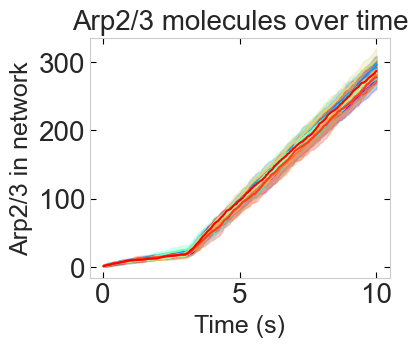

In [32]:
#plot Arp2/3 molecules over time

fig = plt.figure(figsize=[5,4])
ax = fig.add_axes([0.28, 0.2, 0.6, 0.6])

#assign a color to each run group
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars_indexed(arp_bound_by_group_mean_all["%s"%group], arp_bound_by_group_std_all["%s"%group], c, 'Arp2/3 in network')

plt.title('Arp2/3 molecules over time')

if save_figures == 'yes':    
    plt.savefig(figures_dir+pref+'arp_num_vs_time.png')
    plt.savefig(figures_dir+pref+'arp_num_vs_time.pdf')
    
    arp_bound_by_group_mean_all.to_csv(figures_dir+'bound_arp_mean.csv')
    arp_bound_by_group_std_all.to_csv(figures_dir+'bound_arp_std.csv')

## Plot crosslinkers over time

In [33]:
#make lists for the time points and runs in the dataset

time, run = [], [] #make lists for time and run values

#for each couple item (v) in each index (run and time, k) in xlinks_state, append the 1 index to time and the 0 index to run
for k, v in xlinks_state.couple.items(): 
    time.append(k[1])
    run.append(k[0])

#add columns to xlinks_state for test_time and test_run from the time and run lists
xlinks_state['Test_time'] = pd.Series(time, index=xlinks_state.index)
xlinks_state['Test_run'] = pd.Series(run, index=xlinks_state.index)

#runs is a sorted list of the unique values in the test_run column of xlinks_state
runs   = sorted(list(set(xlinks_state.Test_run)), key = lambda x:int(x[-2:]))
#times is a sorted list of the unique values in the test_column of xlinks_state
times = sorted(list(set(xlinks_state.Test_time)))

xlinks_state

couple  total  active    FF  AF  FA   AA  bound  \
run          time    id                                                         
run0004_0002 0.0000  0   crosslinker   1000    1000  1000   0   0    0      0   
             0.0300  0   crosslinker   1000    1000   999   1   0    0      1   
             0.0600  0   crosslinker   1000    1000   997   1   2    0      3   
             0.0900  0   crosslinker   1000    1000   995   2   3    0      5   
             0.1200  0   crosslinker   1000    1000   993   4   3    0      7   
...                              ...    ...     ...   ...  ..  ..  ...    ...   
run0002_0001 9.8798  0   crosslinker    700     700     9  45  46  600    691   
             9.9098  0   crosslinker    700     700    12  48  47  593    688   
             9.9399  0   crosslinker    700     700    11  46  50  593    689   
             9.9699  0   crosslinker    700     700    11  44  47  598    689   
             10.0000 0   crosslinker    700     700    11  46  46  597    689   

                         Test_time      Test_run  
run          time    id                           
run0004_0002 0.0000  0      0.0000  run0004_0002  
             0.0300  0      0.0300  run0004_0002  
             0.0600  0      0.0600  run0004_0002  
             0.0900  0      0.0900  run0004_0002  
             0.1200  0      0.1200  run0004_0002  
...                            ...           ...  
run0002_0001 9.8798  0      9.8798  run0002_0001  
             9.9098  0      9.9098  run0002_0001  
             9.9399  0      9.9399  run0002_0001  
             9.9699  0      9.9699  run0002_0001  
             10.0000 0     10.0000  run0002_0001  

[23380 rows x 10 columns]

In [34]:
#make a list for the groups of repeated runs in the dataset

run_group = [] #make a list for run_groups

#for every value in the run index (aka every unique value in the Test_run column of xlinks_state)
for x in run:
    run_value = x.split('_')[0] #split the string at the '_' and assign the first item (run****) to run_value
    run_group.append(run_value) #append run_value to the run_group list   

#add a column to xlinks_state for Run_groups using the run_group list and the xlinks_state index
xlinks_state['Run_group'] = pd.Series(run_group, index=xlinks_state.index)

#run_groups is a sorted list of the unique values in the column Run_group
run_groups = sorted(list(set(xlinks_state.Run_group)))

xlinks_state

couple  total  active    FF  AF  FA   AA  bound  \
run          time    id                                                         
run0004_0002 0.0000  0   crosslinker   1000    1000  1000   0   0    0      0   
             0.0300  0   crosslinker   1000    1000   999   1   0    0      1   
             0.0600  0   crosslinker   1000    1000   997   1   2    0      3   
             0.0900  0   crosslinker   1000    1000   995   2   3    0      5   
             0.1200  0   crosslinker   1000    1000   993   4   3    0      7   
...                              ...    ...     ...   ...  ..  ..  ...    ...   
run0002_0001 9.8798  0   crosslinker    700     700     9  45  46  600    691   
             9.9098  0   crosslinker    700     700    12  48  47  593    688   
             9.9399  0   crosslinker    700     700    11  46  50  593    689   
             9.9699  0   crosslinker    700     700    11  44  47  598    689   
             10.0000 0   crosslinker    700     700    11  46  46  597    689   

                         Test_time      Test_run Run_group  
run          time    id                                     
run0004_0002 0.0000  0      0.0000  run0004_0002   run0004  
             0.0300  0      0.0300  run0004_0002   run0004  
             0.0600  0      0.0600  run0004_0002   run0004  
             0.0900  0      0.0900  run0004_0002   run0004  
             0.1200  0      0.1200  run0004_0002   run0004  
...                            ...           ...       ...  
run0002_0001 9.8798  0      9.8798  run0002_0001   run0002  
             9.9098  0      9.9098  run0002_0001   run0002  
             9.9399  0      9.9399  run0002_0001   run0002  
             9.9699  0      9.9699  run0002_0001   run0002  
             10.0000 0     10.0000  run0002_0001   run0002  

[23380 rows x 11 columns]

In [35]:
#generate a df for the number of bound xlinks at the last time point for each run
#generate dfs for the means and stds of bound xlinks for every time point for each group of repeated runs

run_grouped = xlinks_state.groupby(xlinks_state.Run_group)

xlinks_state_by_run_group = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the xlinks_state df that contain the current run group
    xlinks_state_run_group = run_grouped.get_group("%s"%i)
    #append that df to the list of dfs for each run group
    xlinks_state_by_run_group.append(xlinks_state_run_group)

bound_xlinks_by_group_mean = []
bound_xlinks_by_group_std = []
last_tp_bound_xlinks = []

#for each df in the list of dfs by run group
for i in xlinks_state_by_run_group: 
    #take the value in the bound column at the last time point for each run
    last_tp_bound_xlinks_by_run = i.loc[i['Test_time']== 10]['bound']
    #reset index and transpose
    last_tp_bound_xlinks_by_run = last_tp_bound_xlinks_by_run.reset_index().drop(['run', 'time', 'id'], axis=1)
    #append to the list of all run groups
    last_tp_bound_xlinks.append(last_tp_bound_xlinks_by_run)
    
    #calculate the means and stds and append them to the list as an item for that run group
    bound_xlinks_by_time_mean = i.groupby(level='time').bound.mean()
    bound_xlinks_by_group_mean.append(bound_xlinks_by_time_mean)
    bound_xlinks_by_time_std = i.groupby(level='time').bound.std()
    bound_xlinks_by_group_std.append(bound_xlinks_by_time_std)

#concatenate into a single data frame with names of each column are run_groups
last_tp_bound_xlinks_all = pd.concat(last_tp_bound_xlinks, axis =1,
                                     keys = run_groups)
bound_xlinks_by_group_mean_all = pd.concat(bound_xlinks_by_group_mean, axis=1,
                                            keys=run_groups)
bound_xlinks_by_group_std_all = pd.concat(bound_xlinks_by_group_std, axis=1,
                                           keys=run_groups)

last_tp_bound_xlinks_all

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
,bound,bound,bound,bound,bound,bound,bound,bound,bound,bound,bound,bound,bound,bound
0,393,543,690,827,980,1105,1258,1398,1586,1903,2530,2815,3251,3342
1,393,542,690,827,970,1124,1250,1375,1563,1886,2405,2823,3060,3370
2,394,547,681,836,978,1114,1261,1411,1542,1894,2487,2856,3092,3529
3,398,539,686,838,980,1110,1264,1388,1582,1891,2496,2819,2916,3212
4,394,544,689,835,974,1110,1251,1385,1579,1878,2498,2718,3032,3030


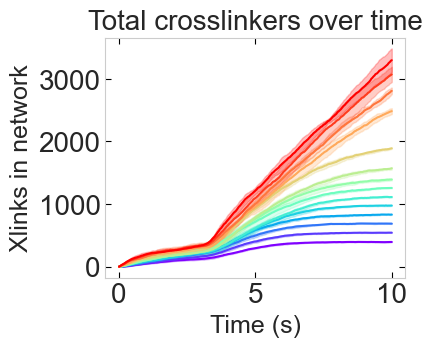

In [36]:
#plot total crosslinkers over time

fig = plt.figure(figsize=[5,4])
ax = fig.add_axes([0.28, 0.2, 0.6, 0.6])

#assign a color to each run group
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars(bound_xlinks_by_group_mean_all["%s"%group], bound_xlinks_by_group_std_all["%s"%group], c, 'Xlinks in network')

plt.title('Total crosslinkers over time')
    
if save_figures == 'yes':
    plt.savefig(figures_dir+pref+'total_xlinks_vs_time.png')
    plt.savefig(figures_dir+pref+'total_xlinks_vs_time.pdf')
    
    bound_xlinks_by_group_mean_all.to_csv(figures_dir+'total_xlinks.csv')
    bound_xlinks_by_group_std_all.to_csv(figures_dir+'total_xlinks_std.csv')
    last_tp_bound_xlinks_all.to_csv(figures_dir+'last_tp_bound_xlinks.csv')

In [37]:
#generate dfs for the means and stds of active xlinks for every time point for each group of repeated runs

active_xlinks_by_group_mean = []
active_xlinks_by_group_std = []
last_tp_active_xlinks = []

#for each df in the list of dfs by run group
for i in xlinks_state_by_run_group:  
    #take the value in the AA column at the last time point for each run
    last_tp_active_xlinks_by_run = i.loc[i['Test_time']== 10]['AA']
    #reset index and transpose
    last_tp_active_xlinks_by_run = last_tp_active_xlinks_by_run.reset_index().drop(['run', 'time', 'id'], axis=1)
    #append to the list of all run groups
    last_tp_active_xlinks.append(last_tp_active_xlinks_by_run)
    
    #calculate the means and stds and append them to the list as an item for that run group
    active_xlinks_by_time_mean = i.groupby(level='time').AA.mean()
    active_xlinks_by_group_mean.append(active_xlinks_by_time_mean)
    active_xlinks_by_time_std = i.groupby(level='time').AA.std()
    active_xlinks_by_group_std.append(active_xlinks_by_time_std)

#concatenate into a single data frame with times as index and names of each column are run_groups
last_tp_active_xlinks_all = pd.concat(last_tp_active_xlinks, axis =1,
                                     keys = run_groups)
active_xlinks_by_group_mean_all = pd.concat(active_xlinks_by_group_mean, axis=1,
                                            keys=run_groups)
active_xlinks_by_group_std_all = pd.concat(active_xlinks_by_group_std, axis=1,
                                           keys=run_groups)

last_tp_active_xlinks_all

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA
0,344,489,595,716,805,897,1043,1094,1229,1424,1662,1508,1642,1465
1,354,463,602,716,785,929,1013,1071,1174,1386,1466,1520,1459,1468
2,363,466,594,719,844,945,1003,1147,1179,1414,1572,1526,1539,1563
3,353,486,583,728,832,898,1039,1143,1241,1432,1579,1545,1419,1449
4,356,484,597,734,818,918,1007,1128,1224,1429,1565,1414,1463,1366


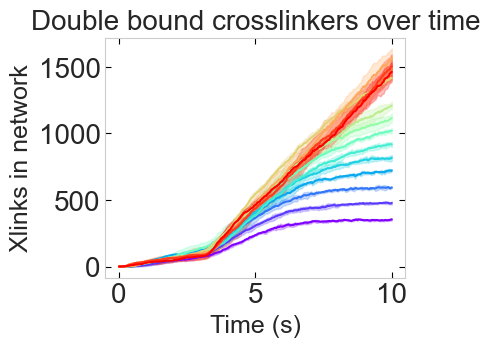

In [38]:
#plot double bound crosslinkers over time

fig = plt.figure(figsize=[5,4])
ax = fig.add_axes([0.28, 0.2, 0.6, 0.6])

#assign a color to each run group
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars(active_xlinks_by_group_mean_all["%s"%group], active_xlinks_by_group_std_all["%s"%group], c, 'Xlinks in network')

plt.title('Double bound crosslinkers over time')

if save_figures == 'yes':
    plt.savefig(figures_dir+pref+'double_bound_xlinks_vs_time.png')
    plt.savefig(figures_dir+pref+'double_bound_xlinks_vs_time.pdf')
    
    active_xlinks_by_group_mean_all.to_csv(figures_dir+'active_xlinks.csv')
    active_xlinks_by_group_std_all.to_csv(figures_dir+'active_xlinks_std.csv')
    last_tp_active_xlinks_all.to_csv(figures_dir+'last_tp_active_xlinks.csv')

## Plot actin length over time

In [39]:
#make lists for the time points and runs in the dataset

time, run = [], [] #make lists for time and run values

#for each fiber_id item (v) in each index (run and time, k) in actin_ends, append the 1 index to time and the 0 index to run
for k, v in actin_ends.fiber_id.items(): 
    time.append(k[1])
    run.append(k[0])

#add columns to actin_ends for test_time and test_run from the time and run lists
actin_ends['Test_time'] = pd.Series(time, index=actin_ends.index)
actin_ends['Test_run'] = pd.Series(run, index=actin_ends.index)

#runs is a sorted list of the unique values in the test_run column of actin_ends
runs   = sorted(list(set(actin_ends.Test_run)), key = lambda x:int(x[-2:]))
#times is a sorted list of the unique values in the test_column of actin_ends
times = sorted(list(set(actin_ends.Test_time)))

actin_ends

fiber_id  length  minus_state  minus_xpos  minus_ypos  \
run          time  id                                                           
run0011_0001 0.00  1           1   0.030            1   -0.004209    0.014234   
                   2           2   0.030            1   -0.010512   -0.007629   
                   3           3   0.030            1   -0.000780   -0.008449   
             0.03  3           3   0.055            1   -0.004481    0.000304   
                   1           1   0.060            1   -0.004993   -0.003679   
...                          ...     ...          ...         ...         ...   
run0004_0001 10.00 88         88   0.060            1    0.077237   -0.007371   
                   238       238   0.060            1   -0.087405   -0.021556   
                   37         37   0.060            1   -0.017803    0.049458   
                   269       269   0.060            1   -0.045821    0.050840   
                   190       190   0.060            1   -0.092054    0.009090   

                        minus_zpos  minus_xdir  minus_ydir  minus_zdir  \
run          time  id                                                    
run0011_0001 0.00  1     -0.032165    0.280610   -0.948908    0.144330   
                   2     -0.022497    0.700766    0.508627   -0.500226   
                   3     -0.017630    0.051999    0.563243   -0.824654   
             0.03  3     -0.031097   -0.395503    0.882436    0.254723   
                   1     -0.031039   -0.647105   -0.595677    0.475841   
...                            ...         ...         ...         ...   
run0004_0001 10.00 88     0.045120    0.725250   -0.356969   -0.588715   
                   238    0.008069    0.902308   -0.429200    0.040360   
                   37     0.065050   -0.865829    0.129015    0.483420   
                   269    0.004576    0.458633    0.715504   -0.526982   
                   190    0.023121    0.077107   -0.996676    0.026310   

                        plus_state  ...  minus_xpos_recal  minus_ypos_recal  \
run          time  id               ...                                       
run0011_0001 0.00  1             1  ...         -4.209150         14.233600   
                   2             1  ...        -10.511500         -7.629400   
                   3             1  ...         -0.779982         -8.448640   
             0.03  3             1  ...         -0.915640          2.157249   
                   1             1  ...         -1.426950         -1.825750   
...                            ...  ...               ...               ...   
run0004_0001 10.00 88            1  ...         84.050860         -0.955920   
                   238           1  ...        -80.591740        -15.140840   
                   37            1  ...        -10.989440         55.873560   
                   269           1  ...        -39.007440         57.255360   
                   190           1  ...        -85.239840         15.504870   

                        minus_zpos_recal  plus_xpos_recal  plus_ypos_recal  \
run          time  id                                                        
run0011_0001 0.00  1             2.16500         4.209150        -14.23360   
                   2            -7.50340        10.511500          7.62940   
                   3           -12.36980         0.779982          8.44864   
             0.03  3             1.09710       -22.049660         50.87981   
                   1             1.03920       -39.776260        -38.03429   
...                                  ...              ...              ...   
run0004_0001 10.00 88          -75.11960       124.266760        -23.30884   
                   238         -38.06884       -25.714840        -39.09854   
                   37          -95.04990       -56.685740         65.50996   
                   269         -34.57630       -11.909140        100.30976   
                   190         -53.12130   

In [40]:
#make a list for the groups of repeated runs in the dataset

run_group = [] #make a list for run_groups

#for every value in the run index (aka every unique value in the Test_run column of actin_ends)
for x in run:
    run_value = x.split('_')[0] #split the string at the '_' and assign the first item (run****) to run_value
    run_group.append(run_value) #append run_value to the run_group list

#add a column to actin_ends for Run_groups using the run_group list and the actin_ends index
actin_ends['Run_group'] = pd.Series(run_group, index=actin_ends.index)

#run_groups is a sorted list of the unique values in the column Run_group
run_groups = sorted(list(set(actin_ends.Run_group)))

actin_ends

fiber_id  length  minus_state  minus_xpos  minus_ypos  \
run          time  id                                                           
run0011_0001 0.00  1           1   0.030            1   -0.004209    0.014234   
                   2           2   0.030            1   -0.010512   -0.007629   
                   3           3   0.030            1   -0.000780   -0.008449   
             0.03  3           3   0.055            1   -0.004481    0.000304   
                   1           1   0.060            1   -0.004993   -0.003679   
...                          ...     ...          ...         ...         ...   
run0004_0001 10.00 88         88   0.060            1    0.077237   -0.007371   
                   238       238   0.060            1   -0.087405   -0.021556   
                   37         37   0.060            1   -0.017803    0.049458   
                   269       269   0.060            1   -0.045821    0.050840   
                   190       190   0.060            1   -0.092054    0.009090   

                        minus_zpos  minus_xdir  minus_ydir  minus_zdir  \
run          time  id                                                    
run0011_0001 0.00  1     -0.032165    0.280610   -0.948908    0.144330   
                   2     -0.022497    0.700766    0.508627   -0.500226   
                   3     -0.017630    0.051999    0.563243   -0.824654   
             0.03  3     -0.031097   -0.395503    0.882436    0.254723   
                   1     -0.031039   -0.647105   -0.595677    0.475841   
...                            ...         ...         ...         ...   
run0004_0001 10.00 88     0.045120    0.725250   -0.356969   -0.588715   
                   238    0.008069    0.902308   -0.429200    0.040360   
                   37     0.065050   -0.865829    0.129015    0.483420   
                   269    0.004576    0.458633    0.715504   -0.526982   
                   190    0.023121    0.077107   -0.996676    0.026310   

                        plus_state  ...  minus_ypos_recal  minus_zpos_recal  \
run          time  id               ...                                       
run0011_0001 0.00  1             1  ...         14.233600           2.16500   
                   2             1  ...         -7.629400          -7.50340   
                   3             1  ...         -8.448640         -12.36980   
             0.03  3             1  ...          2.157249           1.09710   
                   1             1  ...         -1.825750           1.03920   
...                            ...  ...               ...               ...   
run0004_0001 10.00 88            1  ...         -0.955920         -75.11960   
                   238           1  ...        -15.140840         -38.06884   
                   37            1  ...         55.873560         -95.04990   
                   269           1  ...         57.255360         -34.57630   
                   190           1  ...         15.504870         -53.12130   

                        plus_xpos_recal  plus_ypos_recal  plus_zpos_recal  \
run          time  id                                                       
run0011_0001 0.00  1           4.209150        -14.23360         -2.16500   
                   2          10.511500          7.62940          7.50340   
                   3           0.779982          8.44864         12.36980   
             0.03  3         -22.049660         50.87981        -13.19680   
                   1         -39.776260        -38.03429        -27.56318   
...                                 ...              ...              ...   
run0004_0001 10.00 88        124.266760        -23.30884        -36.68482   
                   238       -25.714840        -39.09854        -41.16340   
                   37        -56.685740         65.50996       -132.30600   
                   269       -11.909140        100.30976         -2.78170   
                   190       -82.946240        -44.4103

In [41]:
#growing vs capped ends

#growing filaments are any that are not 60nm
growing_ends = actin_ends.loc[actin_ends['length']!=0.060]
#capped filaments are any that are 60nm
capped_ends  = actin_ends.loc[actin_ends['length']==0.060]

capped_ends

fiber_id  length  minus_state  minus_xpos  minus_ypos  \
run          time  id                                                           
run0011_0001 0.03  1           1    0.06            1   -0.004993   -0.003679   
             0.06  3           3    0.06            1   -0.004900   -0.003057   
                   2           2    0.06            1   -0.000622   -0.002790   
                   1           1    0.06            1   -0.003564   -0.007179   
             0.09  2           2    0.06            1    0.002298   -0.008297   
...                          ...     ...          ...         ...         ...   
run0004_0001 10.00 88         88    0.06            1    0.077237   -0.007371   
                   238       238    0.06            1   -0.087405   -0.021556   
                   37         37    0.06            1   -0.017803    0.049458   
                   269       269    0.06            1   -0.045821    0.050840   
                   190       190    0.06            1   -0.092054    0.009090   

                        minus_zpos  minus_xdir  minus_ydir  minus_zdir  \
run          time  id                                                    
run0011_0001 0.03  1     -0.031039   -0.647105   -0.595677    0.475841   
             0.06  3     -0.031131   -0.718794    0.635037    0.282956   
                   2     -0.031059    0.785693    0.380053    0.488105   
                   1     -0.031082    0.161877   -0.692376    0.703144   
             0.09  2     -0.030932    0.694636   -0.710215    0.114351   
...                            ...         ...         ...         ...   
run0004_0001 10.00 88     0.045120    0.725250   -0.356969   -0.588715   
                   238    0.008069    0.902308   -0.429200    0.040360   
                   37     0.065050   -0.865829    0.129015    0.483420   
                   269    0.004576    0.458633    0.715504   -0.526982   
                   190    0.023121    0.077107   -0.996676    0.026310   

                        plus_state  ...  minus_ypos_recal  minus_zpos_recal  \
run          time  id               ...                                       
run0011_0001 0.03  1             1  ...          -1.82575           1.03920   
             0.06  3             1  ...           1.28053           1.13090   
                   2             1  ...           1.54799           1.05930   
                   1             1  ...          -2.84093           1.08200   
             0.09  2             1  ...          -1.98790           0.93240   
...                            ...  ...               ...               ...   
run0004_0001 10.00 88            1  ...          -0.95592         -75.11960   
                   238           1  ...         -15.14084         -38.06884   
                   37            1  ...          55.87356         -95.04990   
                   269           1  ...          57.25536         -34.57630   
                   190           1  ...          15.50487         -53.12130   

                        plus_xpos_recal  plus_ypos_recal  plus_zpos_recal  \
run          time  id                                                       
run0011_0001 0.03  1          -39.77626        -38.03429       -27.563180   
             0.06  3          -45.11636         39.15102       -16.109000   
                   2           50.06594         21.21112       -29.559609   
                   1           10.96402        -43.31028       -41.676000   
             0.09  2           40.47523        -46.46537        -5.344600   
...                                 ...              ...              ...   
run0004_0001 10.00 88         124.26676        -23.30884       -36.684820   
                   238        -25.71484        -39.09854       -41.163400   
                   37         -56.68574         65.50996      -132.306000   
                   269        -11.90914        100.30976        -2.781700   
                   190        -82.94624        -44.4103

In [42]:
#generate dfs for the mean and std of active lengths for every time point for each group of repeated runs
#also generate a df for all actin lengths at last time point
run_grouped = actin_ends.groupby(actin_ends.Run_group)

actin_len_by_time_mean_all = []
actin_len_by_time_std_all = []
last_tp_rpos_by_group = []
last_tp_len_by_group = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the actin_ends df that contain the current run group
    actin_ends_run_group = run_grouped.get_group("%s"%i)
    #take the length column from the actin_ends df
    actin_len_run_group = actin_ends_run_group['length']
    
    #calculate the means and stds and append them to the list as an item for that run group
    actin_len_by_time_mean = actin_len_run_group.groupby(level=["time"]).mean()
    actin_len_by_time_mean_all.append(actin_len_by_time_mean)    
    actin_len_by_time_std = actin_len_run_group.groupby(level=["time"]).std()
    actin_len_by_time_std_all.append(actin_len_by_time_std)
    
    #take the rpos and length columns for all filaments at the 10 sec timepoint, organized by run group
    last_tp_run_group = actin_ends_run_group.loc[actin_ends_run_group['Test_time']==10.00]
    last_tp_rpos_run_group = last_tp_run_group['plus_rpos_recal']
    last_tp_len_run_group = last_tp_run_group.length
    last_tp_rpos_run_group.reset_index(drop=True, inplace=True)
    last_tp_len_run_group.reset_index(drop=True, inplace=True)
    #append to the list of all run groups
    last_tp_rpos_by_group.append(last_tp_rpos_run_group)
    last_tp_len_by_group.append(last_tp_len_run_group)

#concatenate into a single data frame with names of each column are run_groups
actin_len_by_group_mean_all = pd.concat(actin_len_by_time_mean_all, axis=1,
                                            keys=run_groups)
actin_len_by_group_std_all = pd.concat(actin_len_by_time_std_all, axis=1,
                                           keys=run_groups)
last_tp_rpos_by_group_all = pd.concat(last_tp_rpos_by_group, axis=1,
                                    keys=run_groups)
last_tp_len_by_group_all = pd.concat(last_tp_len_by_group, axis=1,
                                            keys=run_groups)

last_tp_rpos_by_group_all

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
0,63.200994,87.830383,45.379502,18.124364,97.234992,101.703472,127.469492,34.274446,94.063961,51.602633,93.922048,79.061960,92.517209,39.422887
1,89.501771,93.049336,111.122708,53.529701,131.119496,107.407772,112.606459,73.840374,70.969219,125.592814,113.105118,39.450957,47.725571,58.214816
2,66.973970,114.263051,138.058998,44.705571,91.101597,57.954431,115.321699,47.285695,95.486798,92.103332,36.329952,95.668011,138.090202,129.724257
3,64.615046,167.647687,128.884395,63.288402,53.980445,127.718950,69.107050,88.142872,87.411635,44.670464,132.037933,65.777400,59.131740,62.269421
4,101.515488,171.908186,125.645648,90.177293,70.640420,104.499072,56.920801,78.710411,50.046118,45.800050,70.062844,46.901164,87.471845,26.552812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.471805,NaN,NaN,NaN,NaN
1545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.910531,NaN,NaN,NaN,NaN
1546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.868152,NaN,NaN,NaN,NaN
1547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.075203,NaN,NaN,NaN,NaN


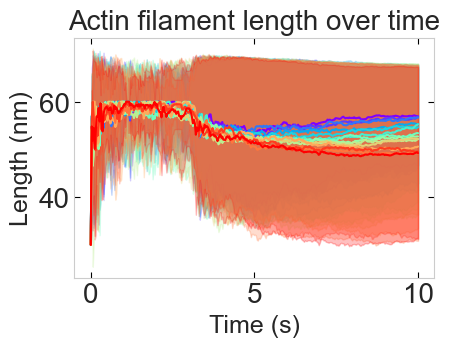

In [43]:
#plot actin filament length over time
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.28, 0.2, 0.6, 0.6])

#assign a color to each run group
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars(actin_len_by_group_mean_all["%s"%group]*1000, actin_len_by_group_std_all["%s"%group]*1000, c, 'Length (nm)')

plt.title('Actin filament length over time')
    
if save_figures == 'yes':
    plt.savefig(figures_dir+pref+'actin_length_vs_time.png')
    plt.savefig(figures_dir+pref+'actin_length_vs_time.pdf')
    
    actin_len_by_group_mean_all.to_csv(figures_dir+'actin_len_mean.csv')
    actin_len_by_group_std_all.to_csv(figures_dir+'actin_len_std.csv')
    last_tp_rpos_by_group_all.to_csv(figures_dir+'last_tp_actin_rpos.csv')
    last_tp_len_by_group_all.to_csv(figures_dir+'last_tp_actin_length.csv')

## Plot growing and capped ends over time

In [44]:
#generate dfs for the means and stds of growing and capped filaments for every time point for each group of repeated runs
growing_ends_by_time_mean_all = []
growing_ends_by_time_std_all = []

capped_ends_by_time_mean_all = []
capped_ends_by_time_std_all = []

growing_ends_run_grouped = growing_ends.groupby(growing_ends.Run_group)
capped_ends_run_grouped = capped_ends.groupby(capped_ends.Run_group)

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the growing_ends df that contain the current run group
    growing_ends_run_group = growing_ends_run_grouped.get_group("%s"%i)
    #group lines in the df by run and then time and get the number of lines for each time index
    #(each line represents a unique actin filament)
    growing_ends_by_time = growing_ends_run_group.groupby(level=['run','time']).fiber_id.count()
    
    #calculate the means and stds and append them to the list as an item for that run group
    growing_ends_by_time_mean = growing_ends_by_time.groupby('time').mean()
    growing_ends_by_time_mean_all.append(growing_ends_by_time_mean)
    growing_ends_by_time_std = growing_ends_by_time.groupby('time').std()
    growing_ends_by_time_std_all.append(growing_ends_by_time_std)
    
    #make a new df from all the lines in the capped_ends df that contain the current run group
    capped_ends_run_group = capped_ends_run_grouped.get_group("%s"%i)
    #group lines in the df by run and then time and get the number of lines for each time index
    #(each line represents a unique actin filament)
    capped_ends_by_time = capped_ends_run_group.groupby(level=['run','time']).fiber_id.count()
    
    #calculate the means and stds and append them to the list as an item for that run group
    capped_ends_by_time_mean = capped_ends_by_time.groupby('time').mean()
    capped_ends_by_time_mean_all.append(capped_ends_by_time_mean)
    capped_ends_by_time_std = capped_ends_by_time.groupby('time').std()
    capped_ends_by_time_std_all.append(capped_ends_by_time_std)
    
#concatenate into a single data frame with times as index and names of each column are run_groups
growing_ends_by_group_mean_all = pd.concat(growing_ends_by_time_mean_all, axis=1,
                                            keys=run_groups)
growing_ends_by_group_mean_all = growing_ends_by_group_mean_all.sort_index()
growing_ends_by_group_std_all = pd.concat(growing_ends_by_time_std_all, axis=1,
                                           keys=run_groups)
growing_ends_by_group_std_all = growing_ends_by_group_std_all.sort_index()
capped_ends_by_group_mean_all = pd.concat(capped_ends_by_time_mean_all, axis=1,
                                            keys=run_groups)
capped_ends_by_group_mean_all = capped_ends_by_group_mean_all.sort_index()
capped_ends_by_group_std_all = pd.concat(capped_ends_by_time_std_all, axis=1,
                                           keys=run_groups)
capped_ends_by_group_std_all = capped_ends_by_group_std_all.sort_index()

growing_ends_by_group_mean_all

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
time,,,,,,,,,,,,,,
0.0000,3.0,3.0,3.0,3.00,3.0,3.000000,3.0,3.0,3.000000,3.0,3.0,3.000000,3.000000,3.000000
0.0300,1.4,1.2,2.0,2.25,1.5,1.600000,2.0,1.5,2.000000,1.8,2.0,1.800000,1.500000,1.600000
0.0600,1.0,1.0,1.5,1.00,NaN,1.000000,1.0,1.0,2.333333,1.0,NaN,1.666667,NaN,1.000000
0.0900,1.0,1.0,1.5,1.00,1.0,1.000000,1.0,1.0,2.500000,1.0,NaN,1.750000,1.000000,1.000000
0.1200,1.0,1.0,1.0,1.60,1.0,1.333333,1.0,1.5,3.000000,1.0,NaN,1.333333,1.666667,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.8798,28.6,37.8,36.0,48.80,56.2,53.800000,63.6,65.6,73.000000,74.8,82.6,85.200000,82.800000,91.400000
9.9098,29.4,39.4,36.8,48.40,58.4,53.000000,63.6,66.2,73.600000,75.6,82.2,85.600000,84.800000,90.800000
9.9399,29.8,38.8,37.0,50.60,58.4,52.000000,63.4,67.4,74.600000,77.2,83.2,86.200000,84.200000,90.800000


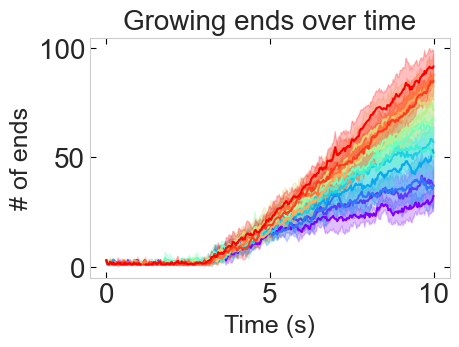

In [45]:
#plot growing ends over time
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.28, 0.2, 0.6, 0.6])

#assign a color to each run group
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars(growing_ends_by_group_mean_all["%s"%group], growing_ends_by_group_std_all["%s"%group], c, '# of ends')

plt.title('Growing ends over time')

if save_figures == 'yes':    
    plt.savefig(figures_dir+pref+'growing_ends_vs_time.png')
    plt.savefig(figures_dir+pref+'growing_ends_vs_time.pdf')

    growing_ends_by_group_mean_all.to_csv(figures_dir+'growing_ends_mean.csv')
    growing_ends_by_group_std_all.to_csv(figures_dir+'growing_ends_std.csv')

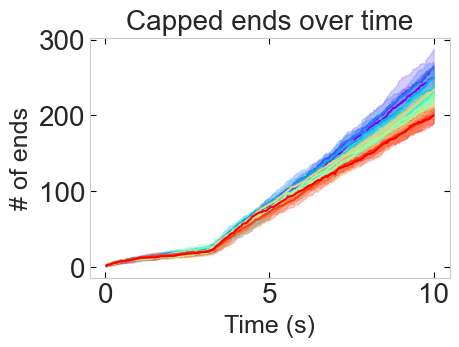

In [46]:
#plot capped ends over time
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.28, 0.2, 0.6, 0.6])

#assign a color to each run group
n=len(run_groups)
color = iter(cm.rainbow(np.linspace(0, 1, n)))

#call plot_multiple_errorbars for each run group to plot in a single figure
for group in run_groups:
    c=next(color)
    plot_multiple_errorbars(capped_ends_by_group_mean_all["%s"%group], capped_ends_by_group_std_all["%s"%group], c, '# of ends')

plt.title('Capped ends over time')
    
if save_figures == 'yes':
    plt.savefig(figures_dir+pref+'capped_ends_vs_time.png')
    plt.savefig(figures_dir+pref+'capped_ends_vs_time.pdf')

    capped_ends_by_group_mean_all.to_csv(figures_dir+'capped_ends_mean.csv')
    capped_ends_by_group_std_all.to_csv(figures_dir+'capped_ends_std.csv')

## Plot growing and capped ends at membrane

In [47]:
#generate dfs for the means and stds of growing and capped filaments at the membrane for every time point for each group of repeated runs
run_grouped_capped = capped_ends.groupby(capped_ends.Run_group)
run_grouped_growing = growing_ends.groupby(growing_ends.Run_group)

capped_ends_at_membrane_mean_all = []
capped_ends_at_membrane_std_all = []
growing_ends_at_membrane_mean_all = []
growing_ends_at_membrane_std_all = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the df that contain the current run group and take only filaments ends whose zpos is within 10nm of the membrane
    capped_ends_run_group = run_grouped_capped.get_group("%s"%i)
    capped_ends_at_membrane_run_group = capped_ends_run_group.iloc[np.where(capped_ends_run_group['plus_zpos_recal']>-10)]['plus_rpos_recal']
    growing_ends_run_group = run_grouped_growing.get_group("%s"%i)
    growing_ends_at_membrane_run_group = growing_ends_run_group.iloc[np.where(growing_ends_run_group['plus_zpos_recal']>-10)]['plus_rpos_recal']
    
    #group lines in the df by run and then time and get the number of lines for each time index
    #(each line represents a unique actin filament)
    capped_ends_at_membrane_by_run_time = capped_ends_at_membrane_run_group.groupby(level =['run','time']).count()
    growing_ends_at_membrane_by_run_time = growing_ends_at_membrane_run_group.groupby(level =['run','time']).count()
    
    #calculate the means and stds and append them to the list as an item for that run group
    capped_ends_at_membrane_by_group_mean = capped_ends_at_membrane_by_run_time.groupby('time').mean()
    capped_ends_at_membrane_by_group_std = capped_ends_at_membrane_by_run_time.groupby('time').std()
    growing_ends_at_membrane_by_group_mean = growing_ends_at_membrane_by_run_time.groupby('time').mean()
    growing_ends_at_membrane_by_group_std = growing_ends_at_membrane_by_run_time.groupby('time').std()
    
    #append to list of all dfs for all run groups
    capped_ends_at_membrane_mean_all.append(capped_ends_at_membrane_by_group_mean)
    capped_ends_at_membrane_std_all.append(capped_ends_at_membrane_by_group_std)
    growing_ends_at_membrane_mean_all.append(growing_ends_at_membrane_by_group_mean)
    growing_ends_at_membrane_std_all.append(growing_ends_at_membrane_by_group_std)

#concatenate into a single data frame with times as index and names of each column are run_groups
capped_ends_at_membrane_mean = pd.concat(capped_ends_at_membrane_mean_all, axis=1,
                                        keys = run_groups)
capped_ends_at_membrane_mean = capped_ends_at_membrane_mean.sort_index()
capped_ends_at_membrane_std = pd.concat(capped_ends_at_membrane_std_all, axis=1,
                                           keys = run_groups)
capped_ends_at_membrane_std = capped_ends_at_membrane_std.sort_index()
growing_ends_at_membrane_mean = pd.concat(growing_ends_at_membrane_mean_all, axis=1,
                                             keys = run_groups)
growing_ends_at_membrane_mean = growing_ends_at_membrane_mean.sort_index()
growing_ends_at_membrane_std = pd.concat(growing_ends_at_membrane_std_all, axis=1,
                                            keys = run_groups)
growing_ends_at_membrane_std = growing_ends_at_membrane_std.sort_index()

capped_ends_at_membrane_mean
    

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
time,,,,,,,,,,,,,,
0.0300,1.00,1.0,1.000000,1.5,1.000000,1.000000,NaN,1.00,1.000000,NaN,1.5,1.000000,1.0,1.00
0.0600,1.50,1.0,1.250000,1.0,1.000000,1.000000,1.000000,1.00,2.000000,1.500000,1.0,1.666667,NaN,1.00
0.0900,1.50,1.5,2.000000,1.2,NaN,1.500000,1.000000,2.00,1.250000,1.000000,1.0,1.500000,1.0,1.25
0.1200,1.00,2.0,1.333333,2.0,1.333333,1.250000,1.333333,1.25,2.000000,1.000000,1.0,1.333333,1.0,1.00
0.1500,1.25,1.4,1.666667,1.0,1.333333,1.333333,1.500000,1.25,1.666667,1.333333,1.0,1.000000,1.2,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.8798,36.40,37.0,35.400000,35.2,32.000000,26.400000,27.800000,27.20,24.000000,25.000000,19.4,17.600000,17.2,18.00
9.9098,35.80,36.0,34.600000,34.8,33.200000,27.200000,27.000000,26.80,24.200000,24.800000,19.2,17.600000,17.2,18.20
9.9399,37.20,35.8,34.600000,34.6,31.200000,28.800000,27.000000,25.80,23.800000,25.000000,19.6,18.600000,17.8,18.80


In [48]:
if save_figures == 'yes':
    capped_ends_at_membrane_mean.to_csv(figures_dir+'membrane_capped_ends_mean.csv')
    capped_ends_at_membrane_std.to_csv(figures_dir+'membrane_capped_ends_std.csv')
    growing_ends_at_membrane_mean.to_csv(figures_dir+'membrane_growing_ends_mean.csv')
    growing_ends_at_membrane_std.to_csv(figures_dir+'membrane_growing_ends_std.csv')

In [49]:
#calculate total polymerization energy at each time point and sum of entire simulation

#work per actin monomer binding event = 9pN * 2.75nm if actin filament is perpendicular to membrane
WorkPerBinding=24.75 #pN nm

total_pol_energy_by_time_mean_all = []
total_pol_energy_by_time_std_all = []
total_pol_energy_all = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the growing_ends df that contain the current run group
    growing_ends_run_group = run_grouped_growing.get_group('%s'%i)
    #calculate a polymerization energy for each filament given an angle of incidence with the membrane
    growing_ends_run_group = growing_ends_run_group.assign(pol_energy=np.sin(np.deg2rad(growing_ends_run_group['zdir_deg_flip90']))*WorkPerBinding)
    #take only filaments whose end is "contacting" the membrane: 1.375 nm away from membrane
    growing_ends_at_membrane_run_group = growing_ends_run_group.iloc[np.where(growing_ends_run_group['plus_zpos_recal']>-1.375)]
    #take only filaments whose angle of incidence with the membrane is positive (not pointed away from the membrane)
    pol_energy_run_group = growing_ends_at_membrane_run_group.iloc[np.where(growing_ends_at_membrane_run_group['zdir_deg_flip90']>=0)]['pol_energy']
    
    #calculate total energy at each time point and sum for entire simulation
    total_pol_energy_by_time_run_group = pol_energy_run_group.groupby(level=['run','time']).sum('pol_energy')
    total_pol_energy_by_run = total_pol_energy_by_time_run_group.groupby('run').sum()
    total_pol_energy_by_run.reset_index(drop=True, inplace=True)
    #calculate the means and stds for each time point
    total_pol_energy_by_time_mean_run_group = total_pol_energy_by_time_run_group.groupby('time').mean()
    total_pol_energy_by_time_std_run_group = total_pol_energy_by_time_run_group.groupby('time').std()
    
    #append totals, means, and stds to the lists as an item for that run group
    total_pol_energy_all.append(total_pol_energy_by_run)
    total_pol_energy_by_time_mean_all.append(total_pol_energy_by_time_mean_run_group)
    total_pol_energy_by_time_std_all.append(total_pol_energy_by_time_std_run_group)

#concatenate into a single data frame with times as index and names of each column are run_groups
#for mean and std, fill NaN cells with 0
total_pol_energy = pd.concat(total_pol_energy_all, axis=1,
                            keys = run_groups)
    
total_pol_energy_by_time_mean = pd.concat(total_pol_energy_by_time_mean_all, axis=1,
                                    keys = run_groups)
total_pol_energy_by_time_mean = total_pol_energy_by_time_mean.sort_index()
total_pol_energy_by_time_mean = total_pol_energy_by_time_mean.fillna(0)

total_pol_energy_by_time_std = pd.concat(total_pol_energy_by_time_std_all, axis=1,
                                        keys = run_groups)
total_pol_energy_by_time_std = total_pol_energy_by_time_std.sort_index()
total_pol_energy_by_time_std = total_pol_energy_by_time_std.fillna(0)

total_pol_energy

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
0,3737.937178,4615.650680,2909.397301,3930.023741,5039.478330,7358.838899,7170.840059,8969.247750,5123.210062,10303.871605,10991.678701,7937.891911,18366.024041,15829.676319
1,4068.040207,3661.786328,5926.659288,4906.383030,3947.806574,5212.718785,8539.255452,7777.669902,7253.536314,10983.155273,11982.180878,10728.840209,29026.579560,12475.338329
2,3361.449862,5670.117213,7110.296839,6508.655907,6352.607295,4299.736255,6639.340596,8831.083161,6985.874546,10773.355293,11636.022096,18333.379592,11557.794804,14245.947412
3,5555.176839,4163.875958,4802.171945,5516.606356,5606.950593,7385.369094,8768.283661,5743.311770,6315.043727,10803.735079,11194.235246,12380.425647,12422.976068,24581.783114
4,4226.623401,5063.931231,3768.944925,4906.383030,6061.687167,5992.574866,6106.132082,10290.524947,11824.615290,13707.319999,8040.572458,11797.828880,14635.036428,18272.720662


In [110]:
if save_figures == 'yes':
    total_pol_energy.to_csv(figures_dir+'total_pol_energy.csv')
    total_pol_energy_by_time_mean.to_csv(figures_dir+'potential_pol_energy_vs_time_mean.csv')
    total_pol_energy_by_time_std.to_csv(figures_dir+'potential_pol_energy_vs_time_std.csv')

In [50]:
#calculate ratio between growing and capped ends at last time point
last_tp_growing_capped_ratio_all = []
last_tp_growing_ends_all = []
last_tp_capped_ends_all = []

#for each value in the run_groups list
for i in run_groups:
    #make a new df from all the lines in the df that contain the current run group and take only filaments ends whose zpos is within 10nm of the membrane
    capped_ends_run_group = run_grouped_capped.get_group("%s"%i)
    capped_ends_at_membrane_run_group = capped_ends_run_group.iloc[np.where(capped_ends_run_group['plus_zpos_recal']>-10)]
    growing_ends_run_group = run_grouped_growing.get_group("%s"%i)
    growing_ends_at_membrane_run_group = growing_ends_run_group.iloc[np.where(growing_ends_run_group['plus_zpos_recal']>-10)]
    
    #take value in rpos column at last time point
    last_tp_growing_ends_run_group = growing_ends_at_membrane_run_group.loc[growing_ends_run_group['Test_time']==10.00]['plus_rpos_recal']
    #group lines in the df by run and then time and get the number of lines for each time index
    #(each line represents a unique growing end)
    last_tp_growing_ends_by_run = last_tp_growing_ends_run_group.groupby('run').count()
    last_tp_growing_ends_run_group.reset_index(drop=True, inplace=True)
    #append to list of all dfs for all run groups
    last_tp_growing_ends_all.append(last_tp_growing_ends_run_group)

    #take value in rpos column at last time point
    last_tp_capped_ends_run_group = capped_ends_at_membrane_run_group.loc[capped_ends_run_group['Test_time']==10.00]['plus_rpos_recal']
    #group lines in the df by run and then time and get the number of lines for each time index
    #(each line represents a unique capped end)
    last_tp_capped_ends_by_run = last_tp_capped_ends_run_group.groupby('run').count()
    last_tp_capped_ends_run_group.reset_index(drop=True, inplace=True)
    #append to list of all dfs for all run groups
    last_tp_capped_ends_all.append(last_tp_capped_ends_run_group)
    
    #calculate capped end:growing end ratio as capped/growing
    last_tp_growing_capped_ratio_run_group = last_tp_capped_ends_by_run/last_tp_growing_ends_by_run
    last_tp_growing_capped_ratio_run_group.reset_index(drop=True, inplace=True)
    
    #append to list of all dfs for all run groups
    last_tp_growing_capped_ratio_all.append(last_tp_growing_capped_ratio_run_group)

#concatenate into a single data frame with times as index and names of each column are run_groups
last_tp_growing_ends_pos = pd.concat(last_tp_growing_ends_all, axis=1, keys = run_groups)
last_tp_capped_ends_pos = pd.concat(last_tp_capped_ends_all, axis=1, keys = run_groups)
last_tp_growing_capped_ratio = pd.concat(last_tp_growing_capped_ratio_all, axis=1,
                                        keys = run_groups)

last_tp_capped_ends_pos

,run0000,run0001,run0002,run0003,run0004,run0005,run0006,run0007,run0008,run0009,run0010,run0011,run0012,run0013
0,72.720483,167.647687,111.122708,97.903930,143.940729,144.259707,127.017257,78.710411,50.046118,79.000660,132.657061,95.668011,92.517209,100.779375
1,107.924957,87.048749,128.884395,16.928790,84.563645,79.714672,113.205472,104.311073,140.620006,161.413264,134.544414,79.067457,82.738074,100.365726
2,103.719084,146.968076,110.819654,85.294815,94.124026,118.000018,38.114457,110.898322,119.347978,115.839418,107.795042,39.211396,85.701118,87.809504
3,105.921258,89.018368,147.950118,114.227421,109.369950,86.373430,100.688178,125.511335,97.563867,79.548195,73.341627,61.277807,110.778402,122.626253
4,78.682088,148.306638,154.348461,84.370977,141.524311,127.472065,120.406553,107.621820,96.816534,77.605724,81.062889,89.386942,86.914196,116.629650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,NaN,87.961253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,NaN,81.102994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,NaN,71.100767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,NaN,132.331293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
if save_figures == 'yes':
    last_tp_growing_ends_pos.to_csv(figures_dir+'last_tp_membrane_growing_ends.csv')
    last_tp_capped_ends_pos.to_csv(figures_dir+'last_tp_membrane_capped_ends.csv')
    last_tp_growing_capped_ratio.to_csv(figures_dir+'growing_capped_ratio.csv')

In [113]:
print('All done!')

All done!
